Overview:

1. Single Cell Model
2. Network Simulations
3. Fit of the Transfer Function
4. Mean Field Model
5. Whole Brain Model
6. PCI
7. BOLD and FC
8. Dynamical Analysis

Single Cell Model

AdEx: 

$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

In [ ]:
%precision 2
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from brian2 import *
from functions import *

In [2]:
%matplotlib inline


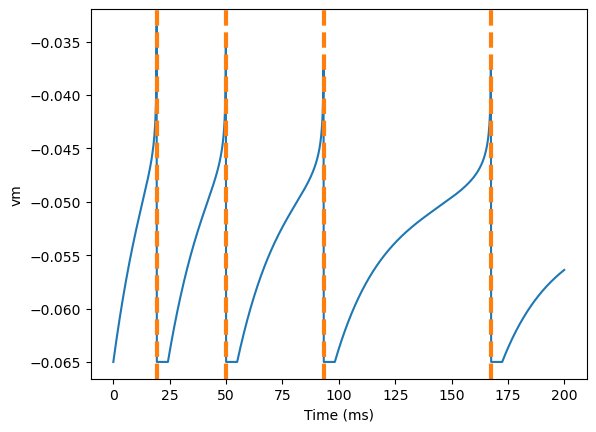

In [13]:
start_scope()
tau = 10*ms
C = 200*pF
gL = 10*nS
tauw = 500*ms
a =.0*nS# 4*nS
Ee=0*mV
Ei=-80*mV
I = .3*nA

b_e = 60
tau_e = 5.0
tau_i = 5.0

EL_i = -65.0
EL_e = -64.0

eqs = """
dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)-GsynE*(vm-Ee)-GsynI*(vm-Ei)+I-w)/C : volt (unless refractory)
dw/dt=(a*(vm-EL)-w)/tauw : amp
dGsynI/dt = -GsynI/TsynI : siemens
dGsynE/dt = -GsynE/TsynE : siemens
TsynI:second
TsynE:second
Vr:volt
b:amp
DeltaT:volt
Vcut:volt
VT:volt
EL:volt
"""

G_exc = NeuronGroup(1, model=eqs, threshold='vm > Vcut',refractory=5*ms,
                     reset="vm = Vr; w += b", method='heun')
G_exc.vm = -65*mV#EL
G_exc.w = a * (G_exc.vm - G_exc.EL)
G_exc.Vr = -65*mV 
G_exc.b=b_e*pA
G_exc.DeltaT=2*mV
G_exc.VT=-50.*mV
# G_exc.Vcut=G_exc.VT + 5 * G_exc.DeltaT
G_exc.Vcut = -30*mV
G_exc.EL=EL_e*mV
G_exc.TsynI =5*ms
G_exc.TsynE =5*ms

statemon = StateMonitor(G_exc, 'vm', record=0)
spikemon = SpikeMonitor(G_exc)

run(200*ms)

plot(statemon.t/ms, statemon.vm[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('vm');

Network Simulations

--##Start simulation##--
--##End simulation##--


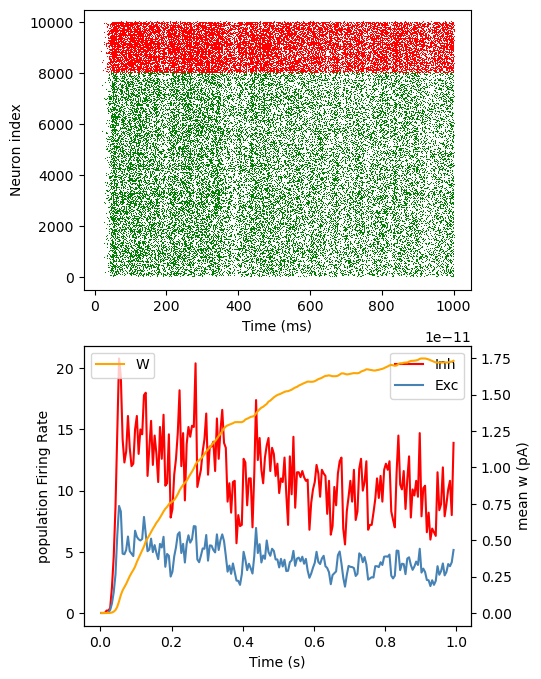

 done


<Figure size 640x480 with 0 Axes>

In [10]:
%run adex_simulation_network.py --b_e=10.0 --iext=0.6

FIT

MEAN FIELD